In [1]:
import pandas as pd 
import numpy as np 
import os 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

# import the preprocessing functions we've made 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/'

import preprocess

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity'

Mounted at /content/gdrive
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [ ]:
dataset = pd.read_csv('data/scarcity_dataset.csv') 
dataset

,Unnamed: 0,ad,scarcity
0,0,Show your support for the environment and for ...,1
1,1,Trumps tippooling move would give more power t...,0
2,2,If this was such an emergency why didnt Trump ...,1
3,3,Here is todays attack from both my opponents f...,0
4,4,BREAKING The Trump Administration may make dra...,1
...,...,...,...
11319,11319,Were running out of time Our EndofQuarter dead...,1
11320,11320,Learn how farmers are using manure and food wa...,0
11321,11321,Make your generosity go twice as far Your Givi...,1
11322,11322,Billionaire industrialist Charles Koch is know...,0


In [ ]:
# data preprocessing 
norm_data = preprocess.preprocess_data(dataset['ad'])

In [3]:
df= pd.read_csv('data/cleaned_scarcity.csv') 
df.head()

,scarcity,preprocessed
0,1,show support environment greener future free l...
1,0,trumps tippooling move would give power busine...
2,1,emergency didnt trump declare two months ago b...
3,0,todays attack opponents progressive race im ha...
4,1,breaking trump administration may make drastic...


In [4]:
# build test and training datasets 
train_data, test_data = preprocess.eval_train_split(df['preprocessed'], df['scarcity'] , test_size = 0.2, validation = False)
norm_train, y_train, norm_test, y_test = train_data[0], train_data[1], test_data[0], test_data[1]

In [5]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('eclectic', 20806), ('<PAD>', 0), 1)

In [6]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train.values.astype('U'))
test_sequences = t.texts_to_sequences(norm_test.values.astype('U'))

In [7]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((8597, 1000), (2150, 1000))

In [8]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a GRU model used for binary text classification task
    Arguments : 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  

  '''
  model = Sequential([
      layers.Embedding(vocab_size, embedding_dim , input_length = maxlen),
      layers.Dropout( rate = dropout ),
      layers.GRU(units),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
!pip install pyyaml h5py

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity/saved_models'

/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity/saved_models


In [9]:
# define the paramters we're using for the model 
embedding_dim = 50
units = 128
vocab_size = len(t.word_index)

model = create_model(units = units , vocab_size = vocab_size, embedding_dim = embedding_dim, maxlen = MAX_SEQUENCE_LENGTH )

In [10]:
batch_size  = 64
history = model.fit(X_train, y_train, epochs= 5, batch_size=batch_size, 
                    shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
108/108 [==============================] - 205s 2s/step - loss: 0.6905 - accuracy: 0.5402 - val_loss: 0.6907 - val_accuracy: 0.5366
Epoch 2/5
108/108 [==============================] - 199s 2s/step - loss: 0.6453 - accuracy: 0.6276 - val_loss: 0.7376 - val_accuracy: 0.5279
Epoch 3/5
108/108 [==============================] - 199s 2s/step - loss: 0.4518 - accuracy: 0.7942 - val_loss: 0.9269 - val_accuracy: 0.5186
Epoch 4/5
108/108 [==============================] - 198s 2s/step - loss: 0.2651 - accuracy: 0.8866 - val_loss: 1.0623 - val_accuracy: 0.4971
Epoch 5/5
108/108 [==============================] - 198s 2s/step - loss: 0.1711 - accuracy: 0.9337 - val_loss: 1.2813 - val_accuracy: 0.5169


In [11]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

68/68 [==============================] - 14s 210ms/step - loss: 1.2740 - accuracy: 0.5084
Accuracy: 50.84%


In [ ]:
# save the model


In [12]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

68/68 [==============================] - 15s 207ms/step


[1, 1, 1, 0, 0, 0, 1, 1, 1, 1]

In [13]:
!pip install scikit-plot
import scikitplot as skplt

              precision    recall  f1-score   support

    scarcity       0.46      0.39      0.42       986
 no-scarcity       0.54      0.61      0.57      1164

    accuracy                           0.51      2150
   macro avg       0.50      0.50      0.50      2150
weighted avg       0.50      0.51      0.50      2150

confusion matrix:
[[386 600]
 [457 707]]



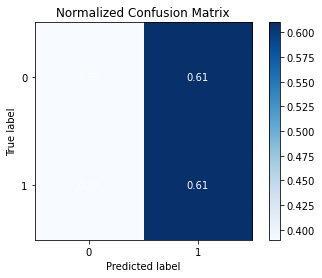

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

print(metrics.classification_report(y_test, predictions, target_names=['scarcity', 'no-scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [ ]:
save = pd.read_csv('/scarcity_no _scarcity_sample.csv')

norm_ = preprocess.preprocess_data(save['ads'])
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['scarcity'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()